## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    fbeta_score, classification_report, confusion_matrix, precision_recall_curve,
    make_scorer
)

from imblearn.over_sampling import SMOTE


## Data loading

Load the training and validation datasets.


In [32]:
train_df = pd.read_csv('train_dataset_final1.csv', sep=',', engine='python', on_bad_lines='skip')
validate_df = pd.read_csv('validate_dataset_final.csv', sep=',', engine='python', on_bad_lines='skip')
display(train_df.head())
display(validate_df.head())

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


## Data exploration


Shape of the DataFrame: (25247, 27)

Data Types:
 Customer_ID             int64
marriage                int64
sex                     int64
education               int64
LIMIT_BAL               int64
age                   float64
pay_0                   int64
pay_2                   int64
pay_3                   int64
pay_4                   int64
pay_5                   int64
pay_6                   int64
Bill_amt1             float64
Bill_amt2             float64
Bill_amt3             float64
Bill_amt4             float64
Bill_amt5             float64
Bill_amt6             float64
pay_amt1              float64
pay_amt2              float64
pay_amt3              float64
pay_amt4              float64
pay_amt5              float64
pay_amt6              float64
AVG_Bill_amt          float64
PAY_TO_BILL_ratio     float64
next_month_default      int64
dtype: object

Descriptive Statistics:
         Customer_ID      marriage           sex     education       LIMIT_BAL  \
count  25247.000000

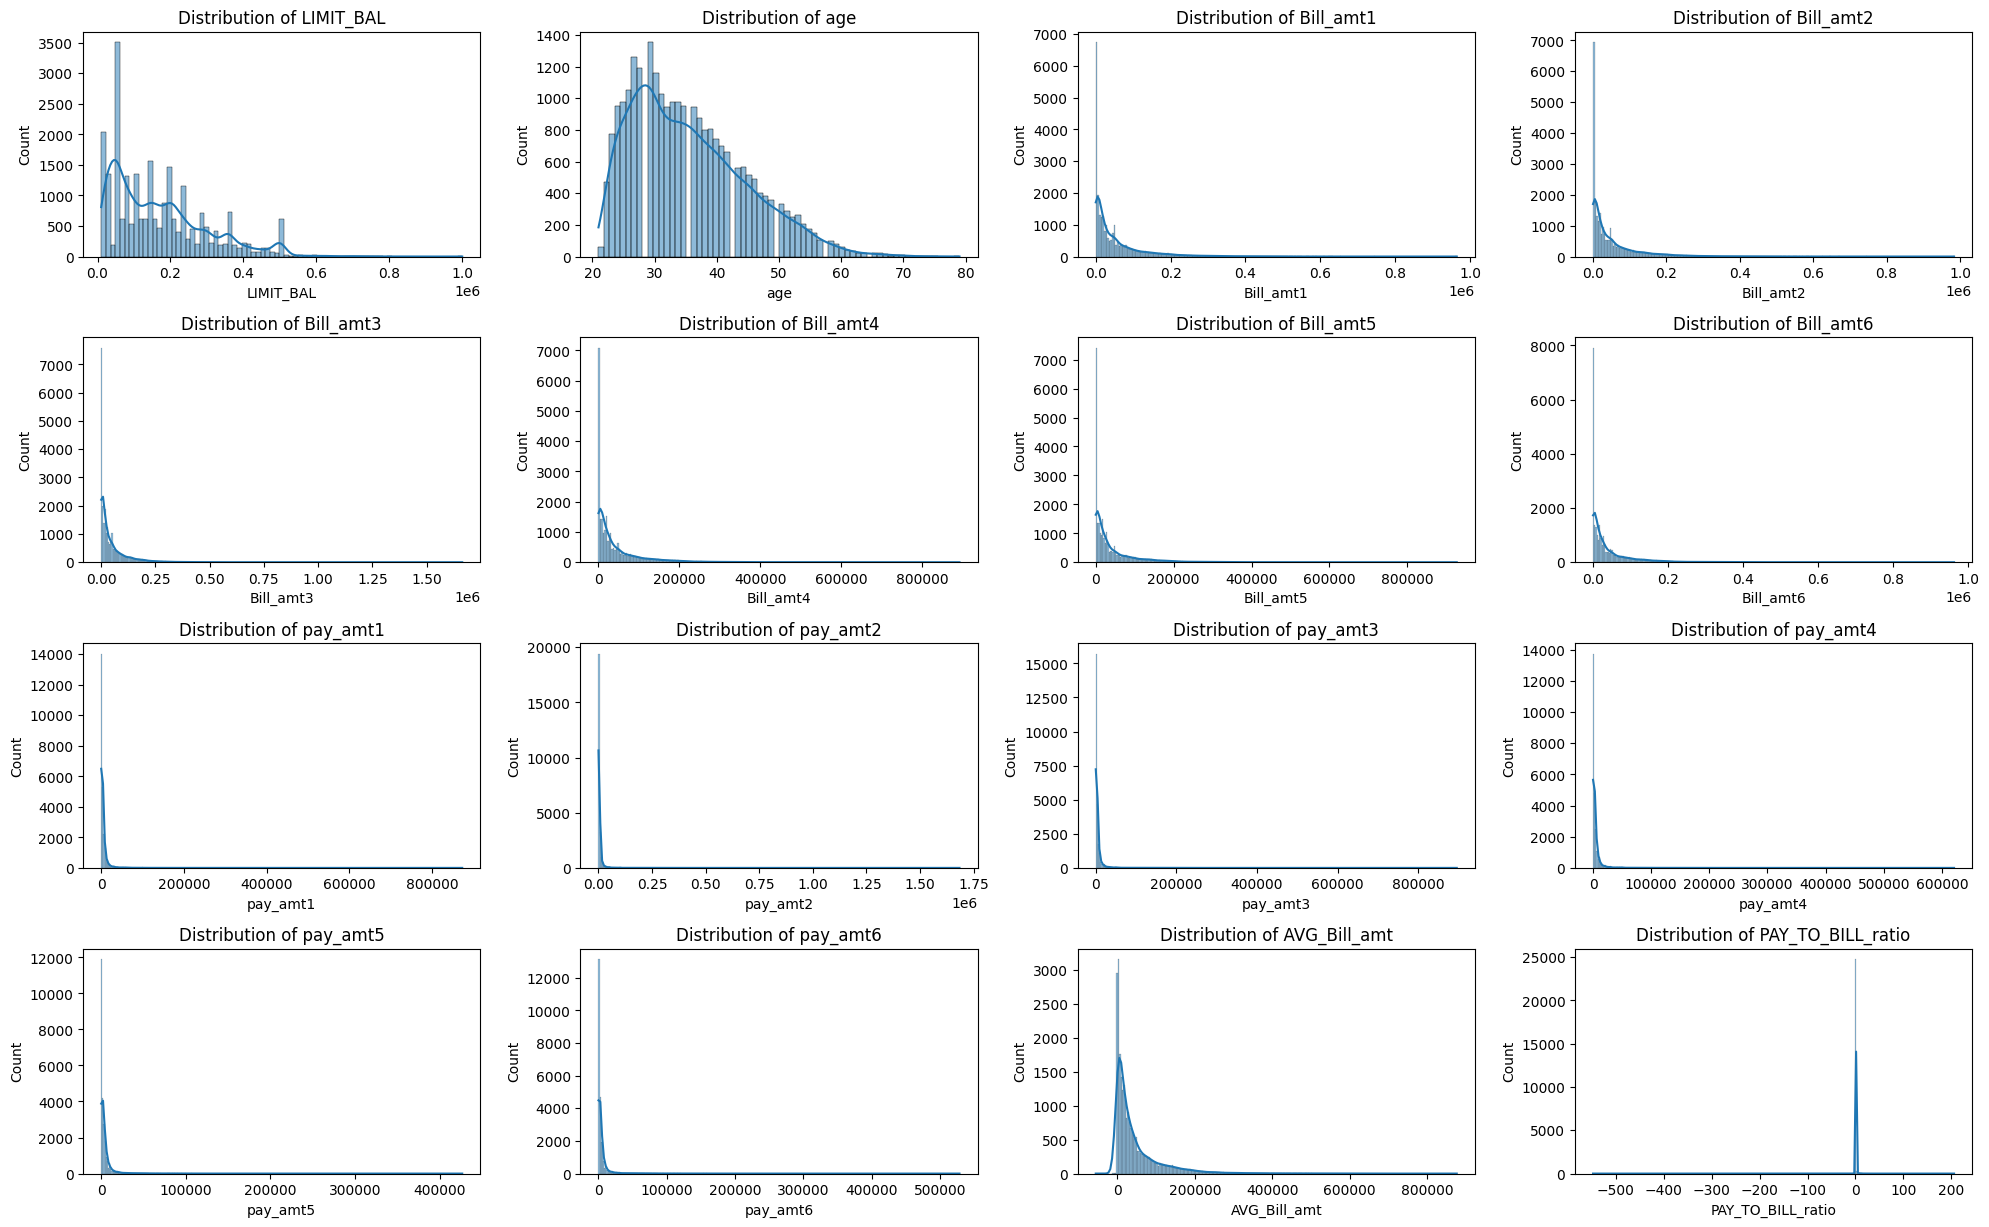

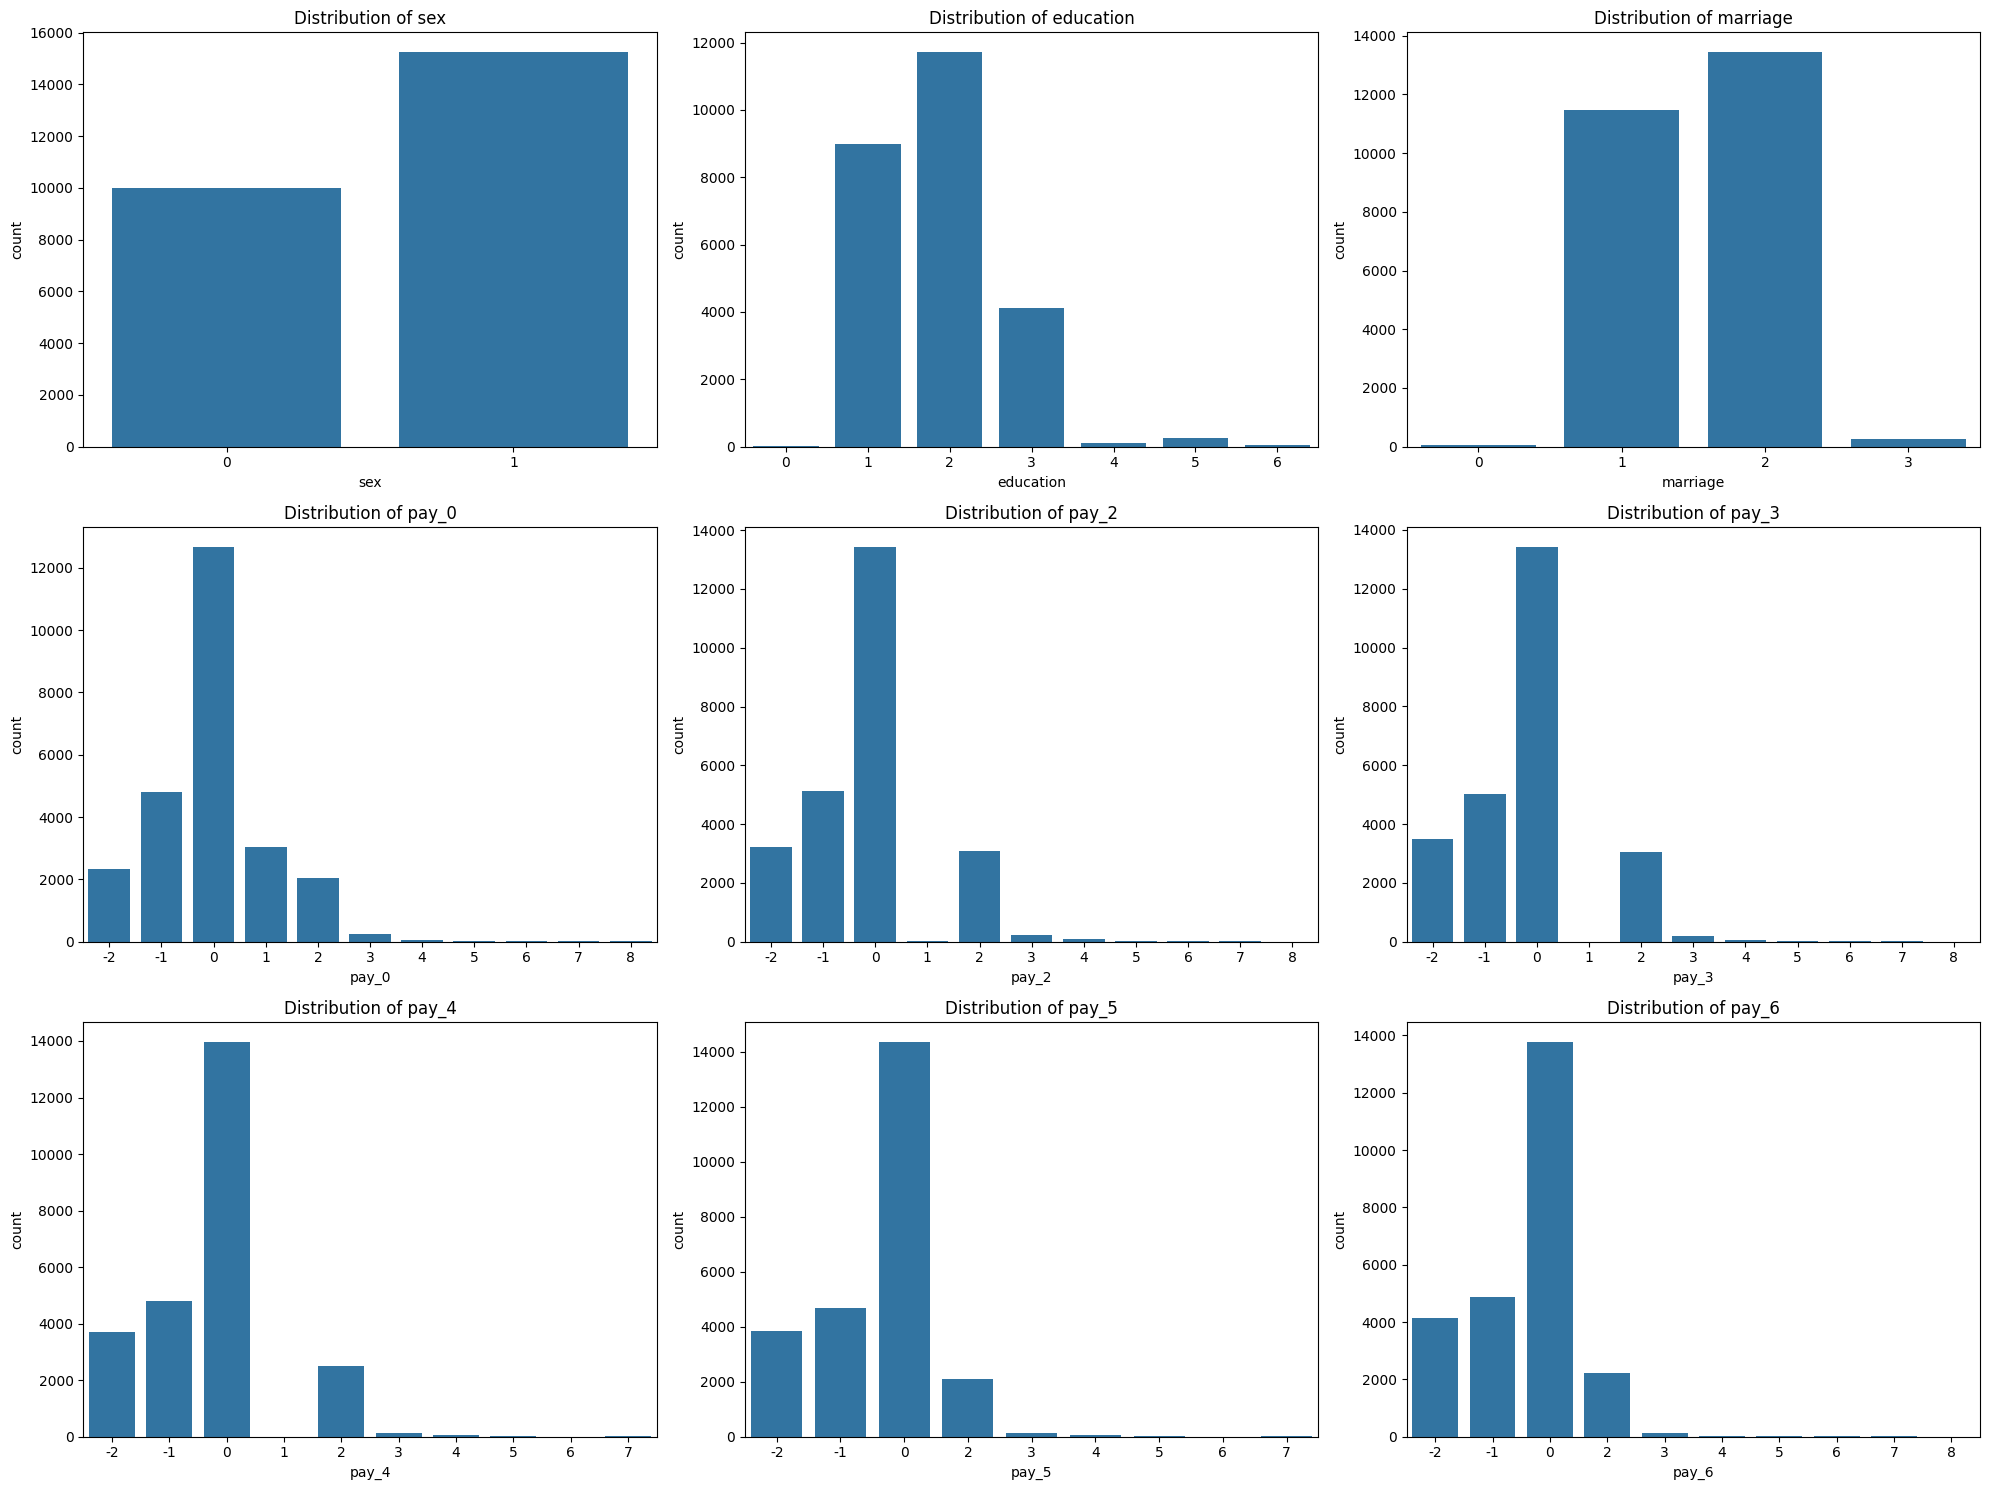

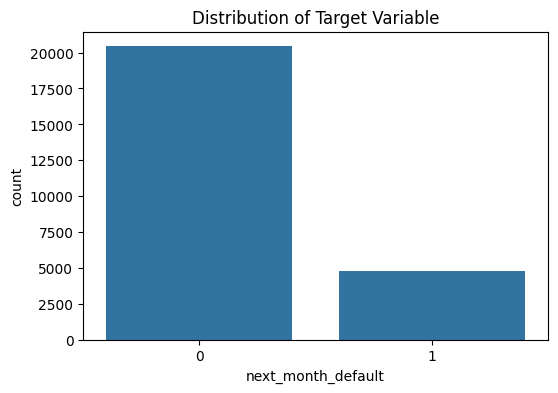


Class Imbalance:
next_month_default
0    20440
1     4807
Name: count, dtype: int64
next_month_default
0    80.960114
1    19.039886
Name: count, dtype: float64


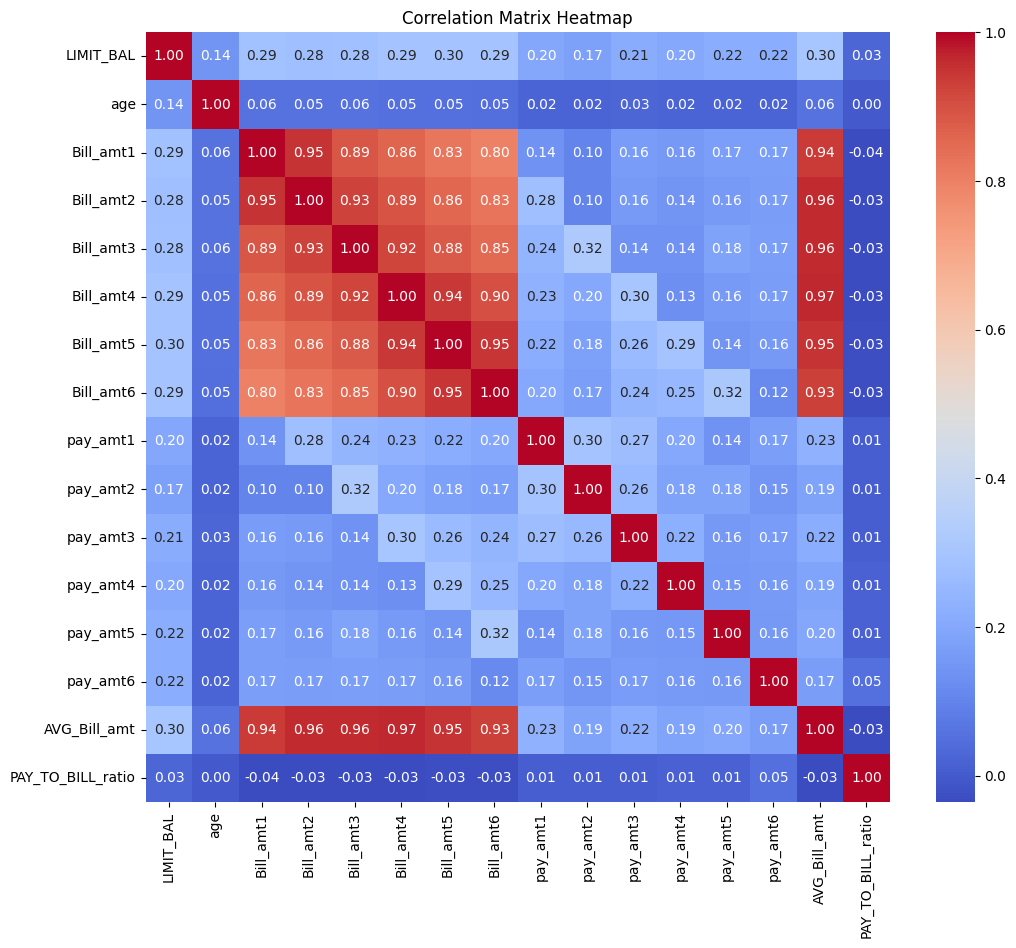

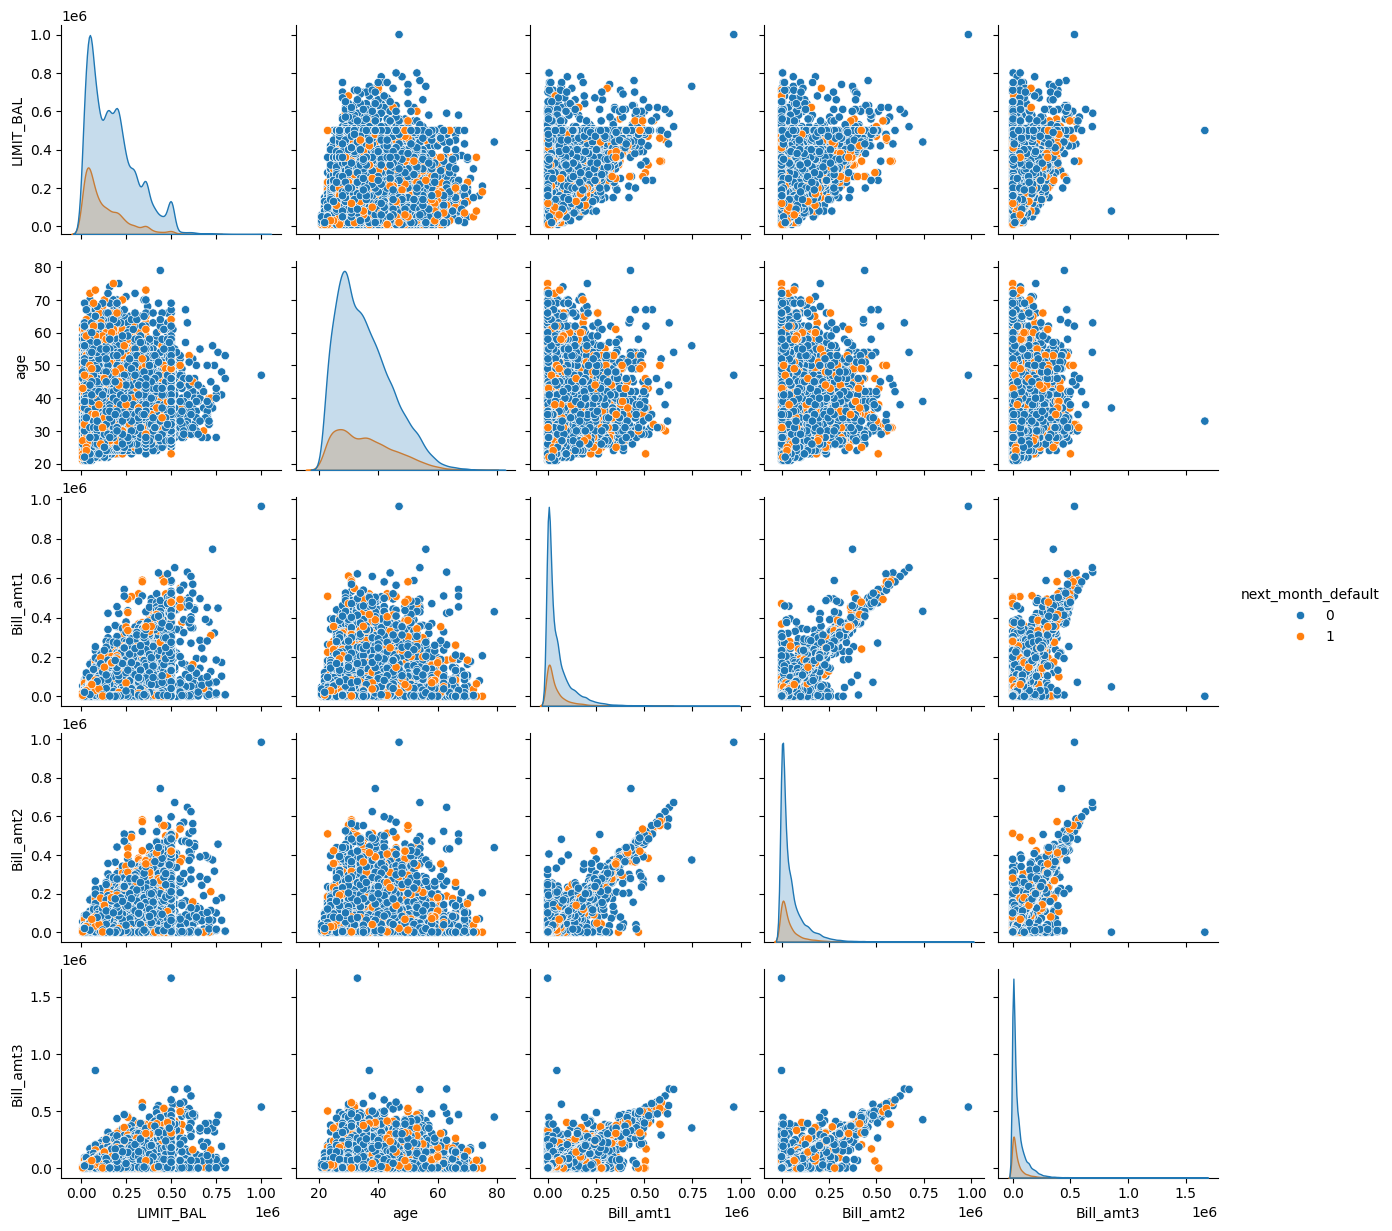

In [8]:

# Basic Exploration
print("Shape of the DataFrame:", train_df.shape)
print("\nData Types:\n", train_df.dtypes)
print("\nDescriptive Statistics:\n", train_df.describe())
print("\nMissing Values:\n", train_df.isnull().sum())

# Distribution Analysis for Numerical Features
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features):
  plt.subplot(5, 4, i + 1)
  sns.histplot(train_df[col], kde=True)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Distribution Analysis for Categorical Features
categorical_features = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, data=train_df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Class Imbalance Calculation
class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print("\nClass Imbalance:")
print(class_counts)
print(class_percentages)


# Correlation Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


# Pairplots
sns.pairplot(train_df[numerical_features[:5] + ['next_month_default']], hue='next_month_default')
plt.show()

## Data cleaning


In [33]:


# Handle missing values
for df in [train_df, validate_df]:
    # Impute missing 'age' with the median
    df['age'] = df['age'].fillna(df['age'].median())

    # Investigate and remove rows with missing 'Customer_ID'
    df.dropna(subset=['Customer_ID'], inplace=True)

# Outlier Treatment (Winsorization)
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
for df in [train_df, validate_df]:
    for col in numerical_features:
        df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))

display(train_df.head())
display(validate_df.head())

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,60.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


## Data analysis


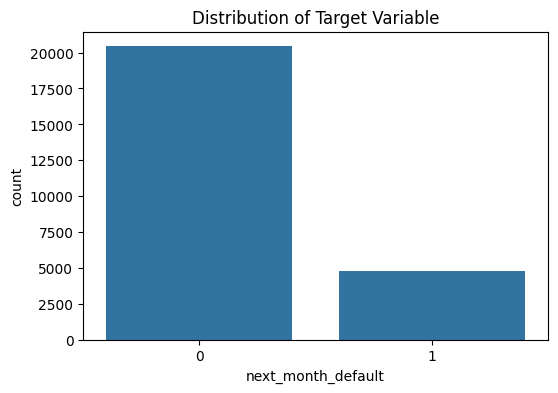


Class Imbalance:
next_month_default
0    20440
1     4807
Name: count, dtype: int64
next_month_default
0    80.960114
1    19.039886
Name: count, dtype: float64


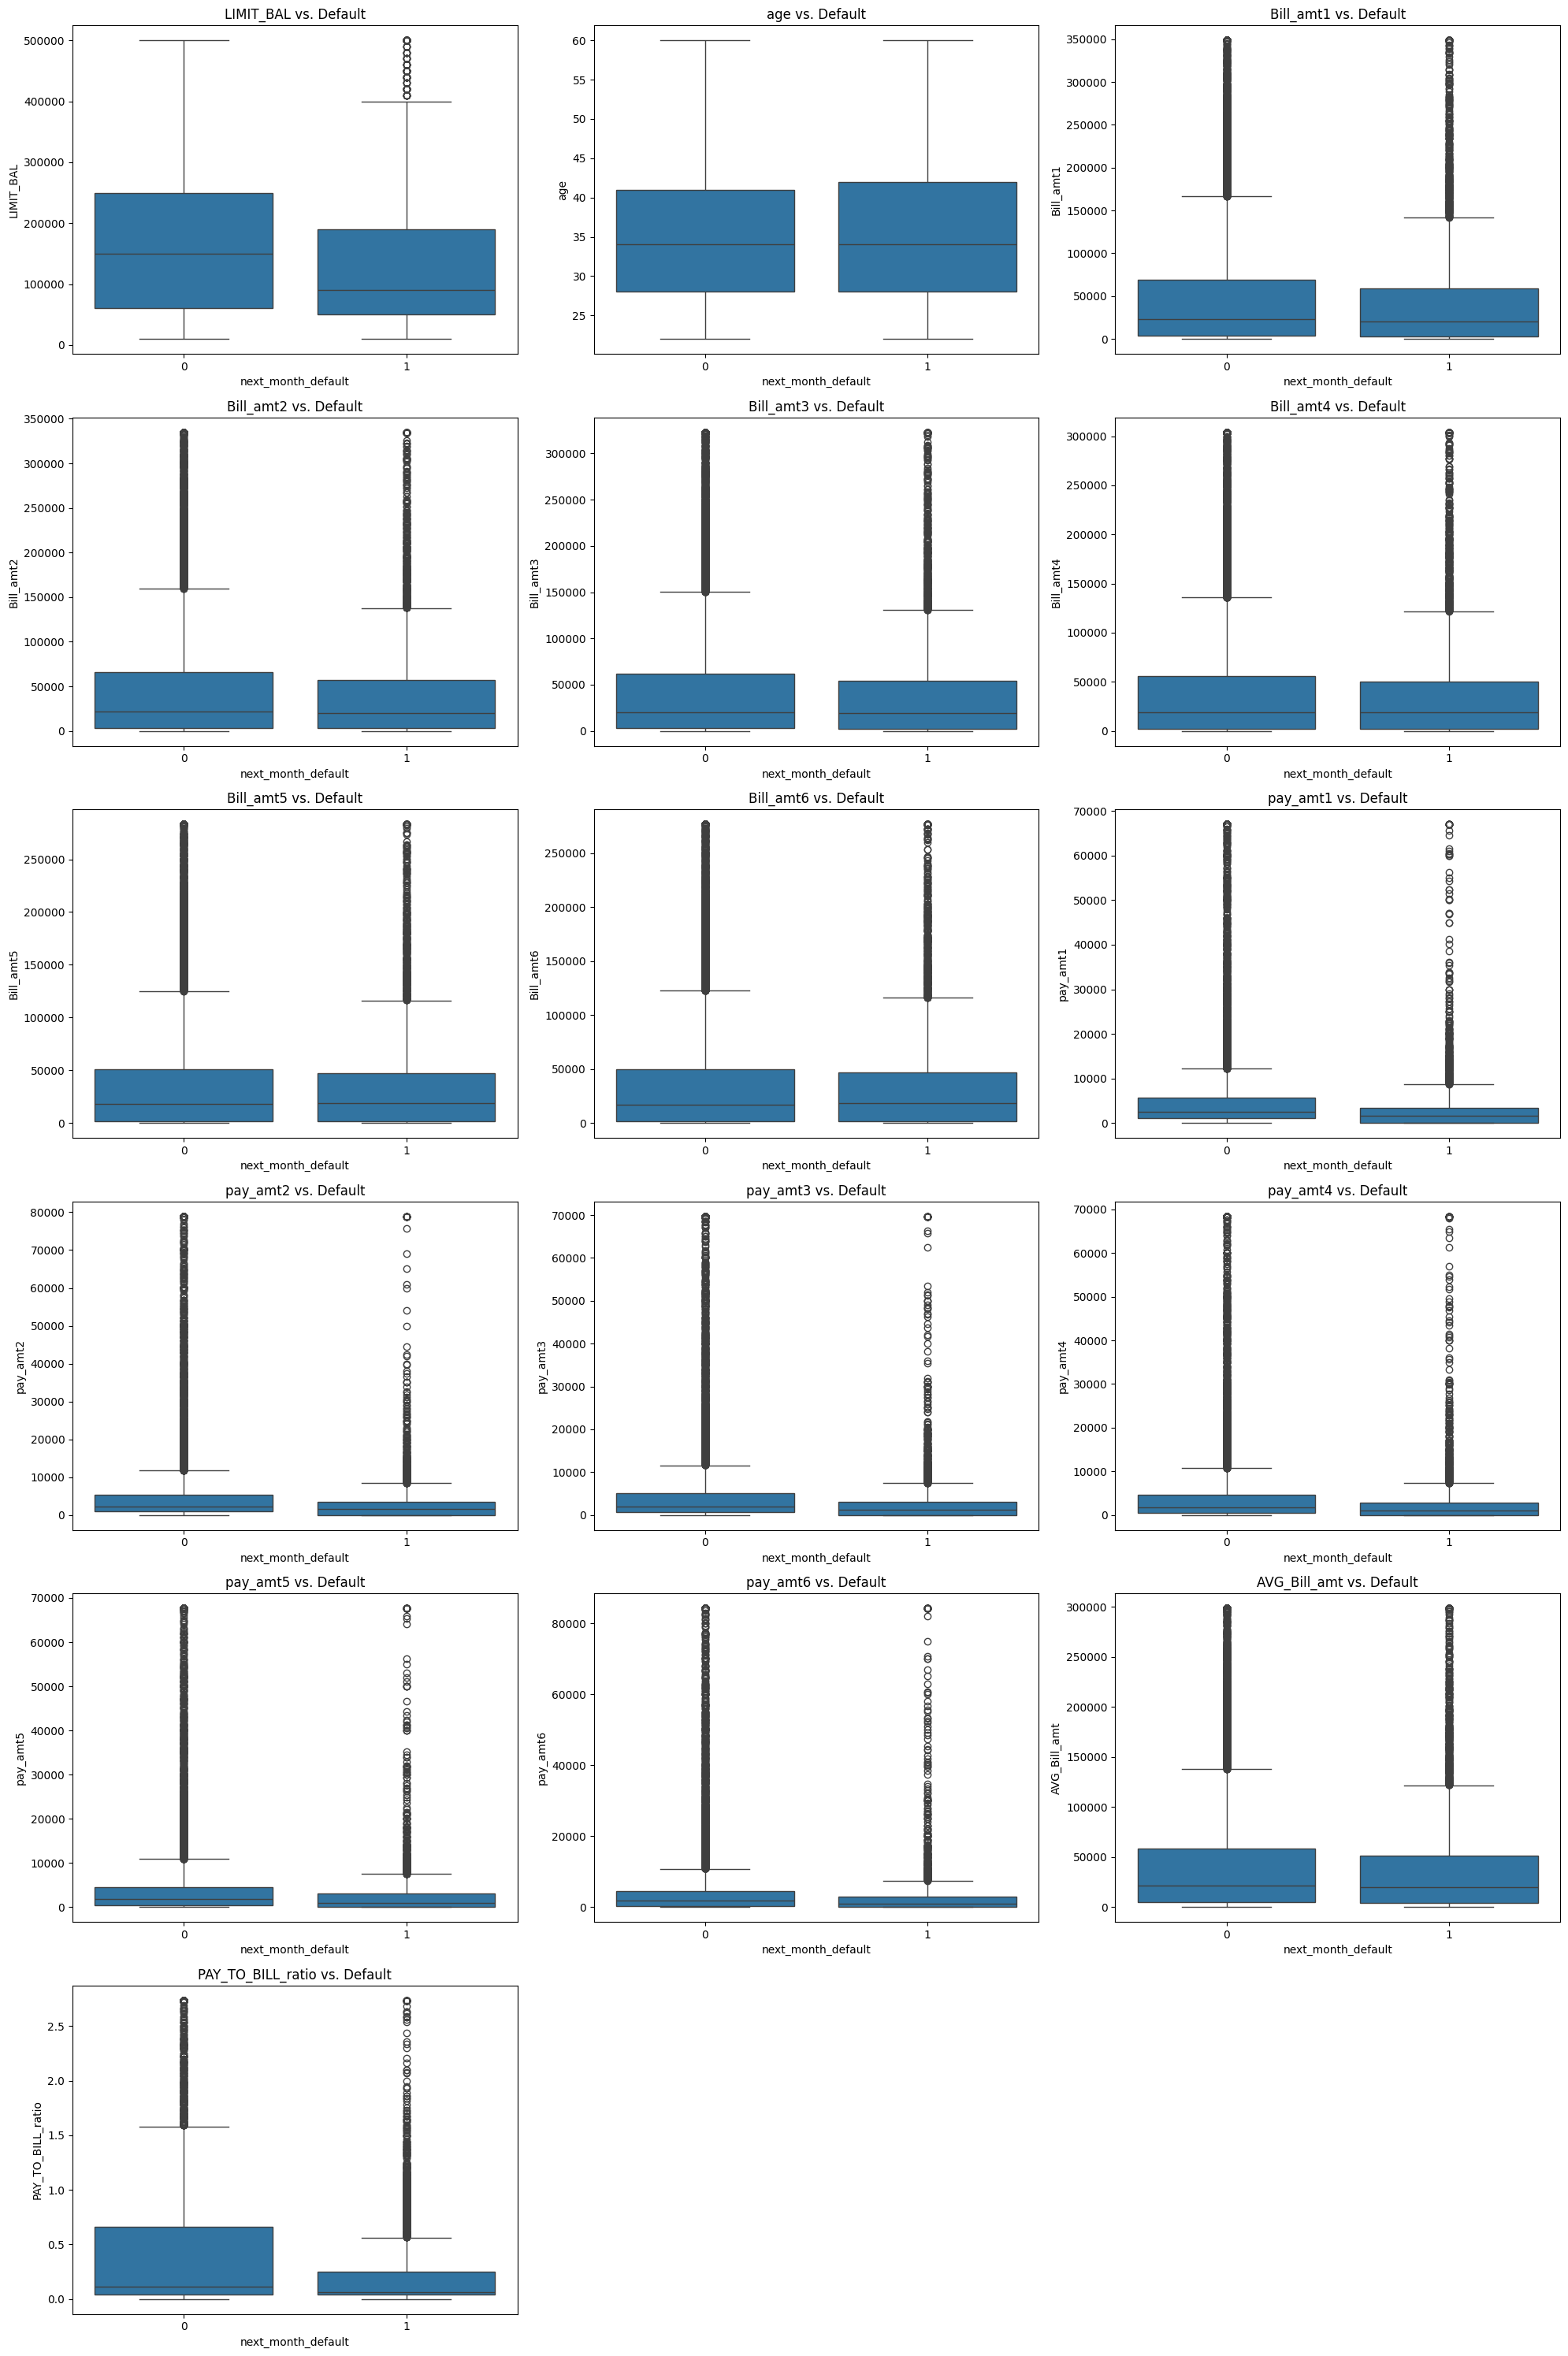

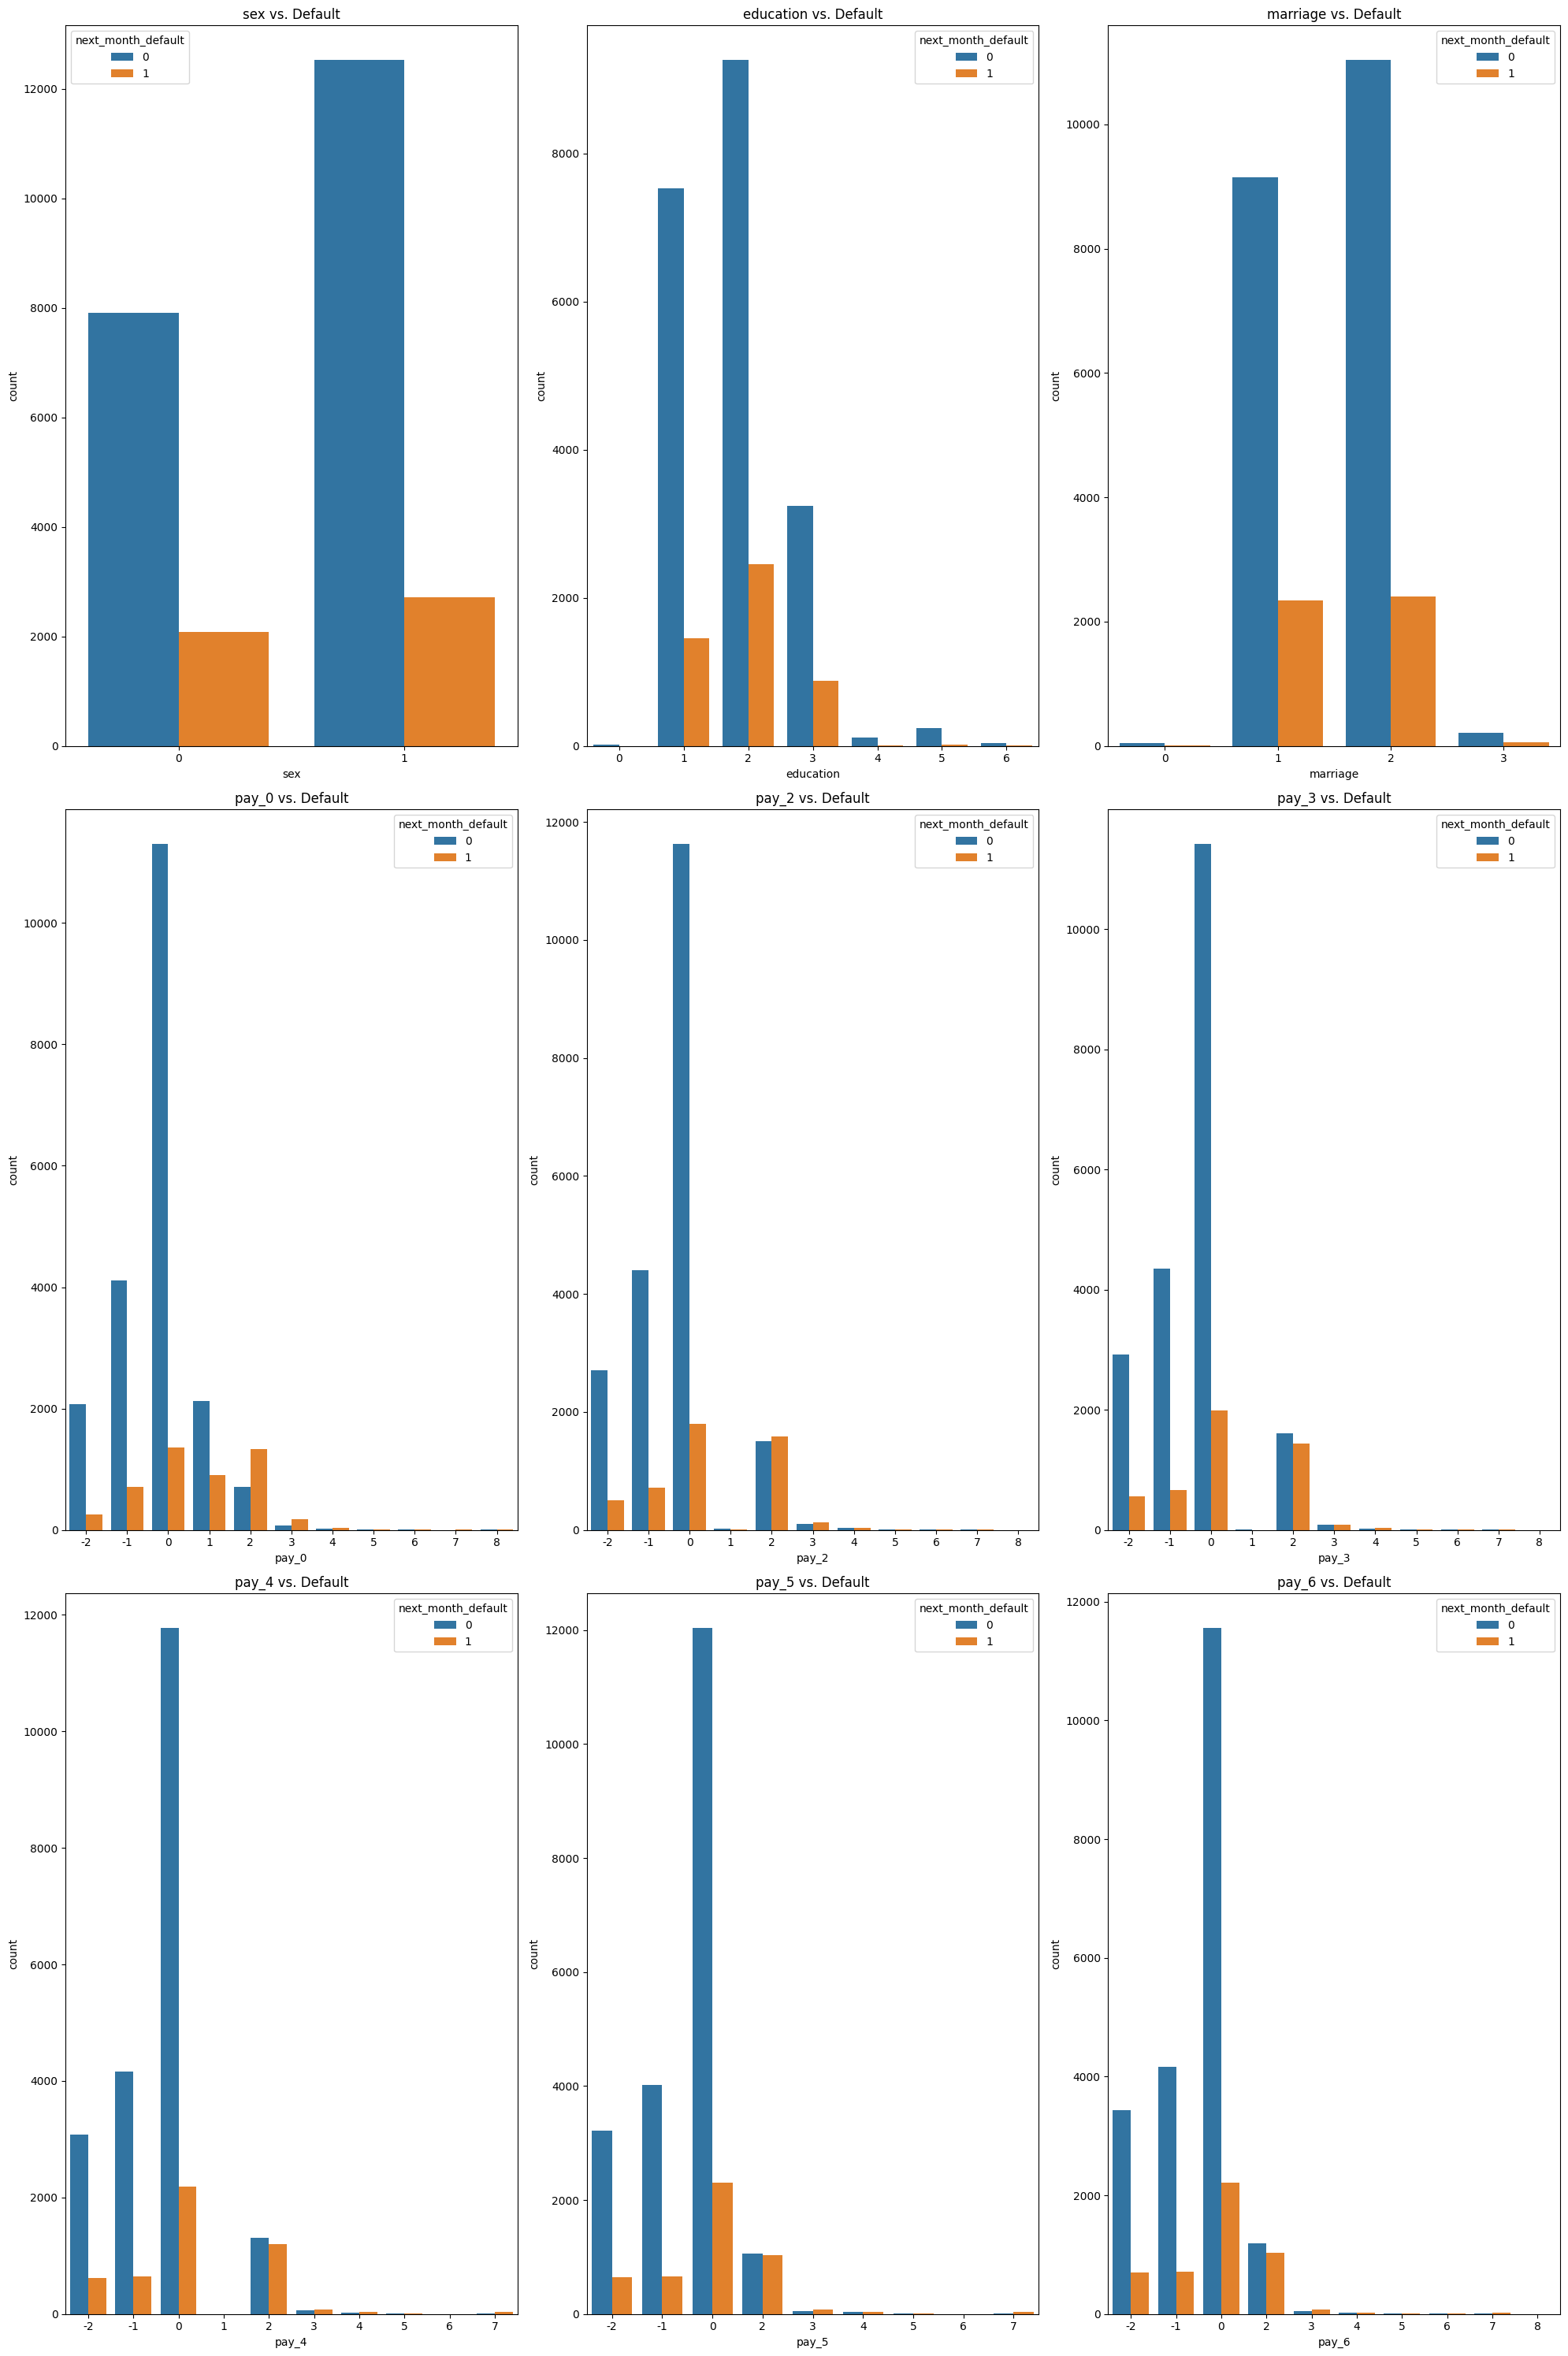

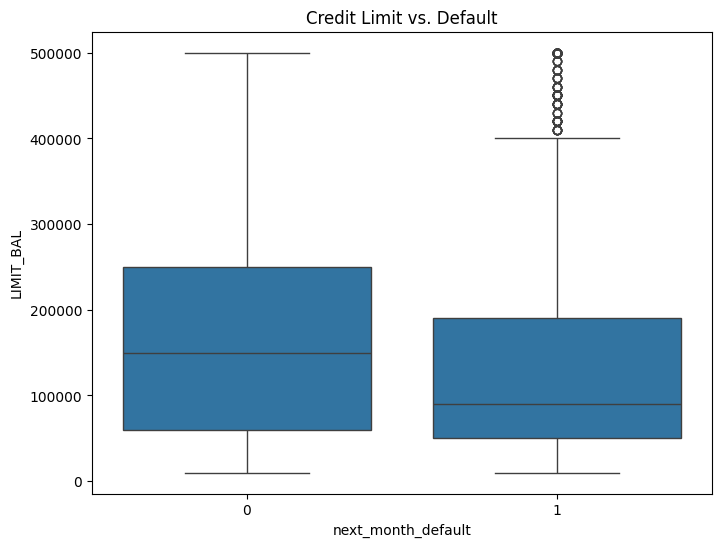

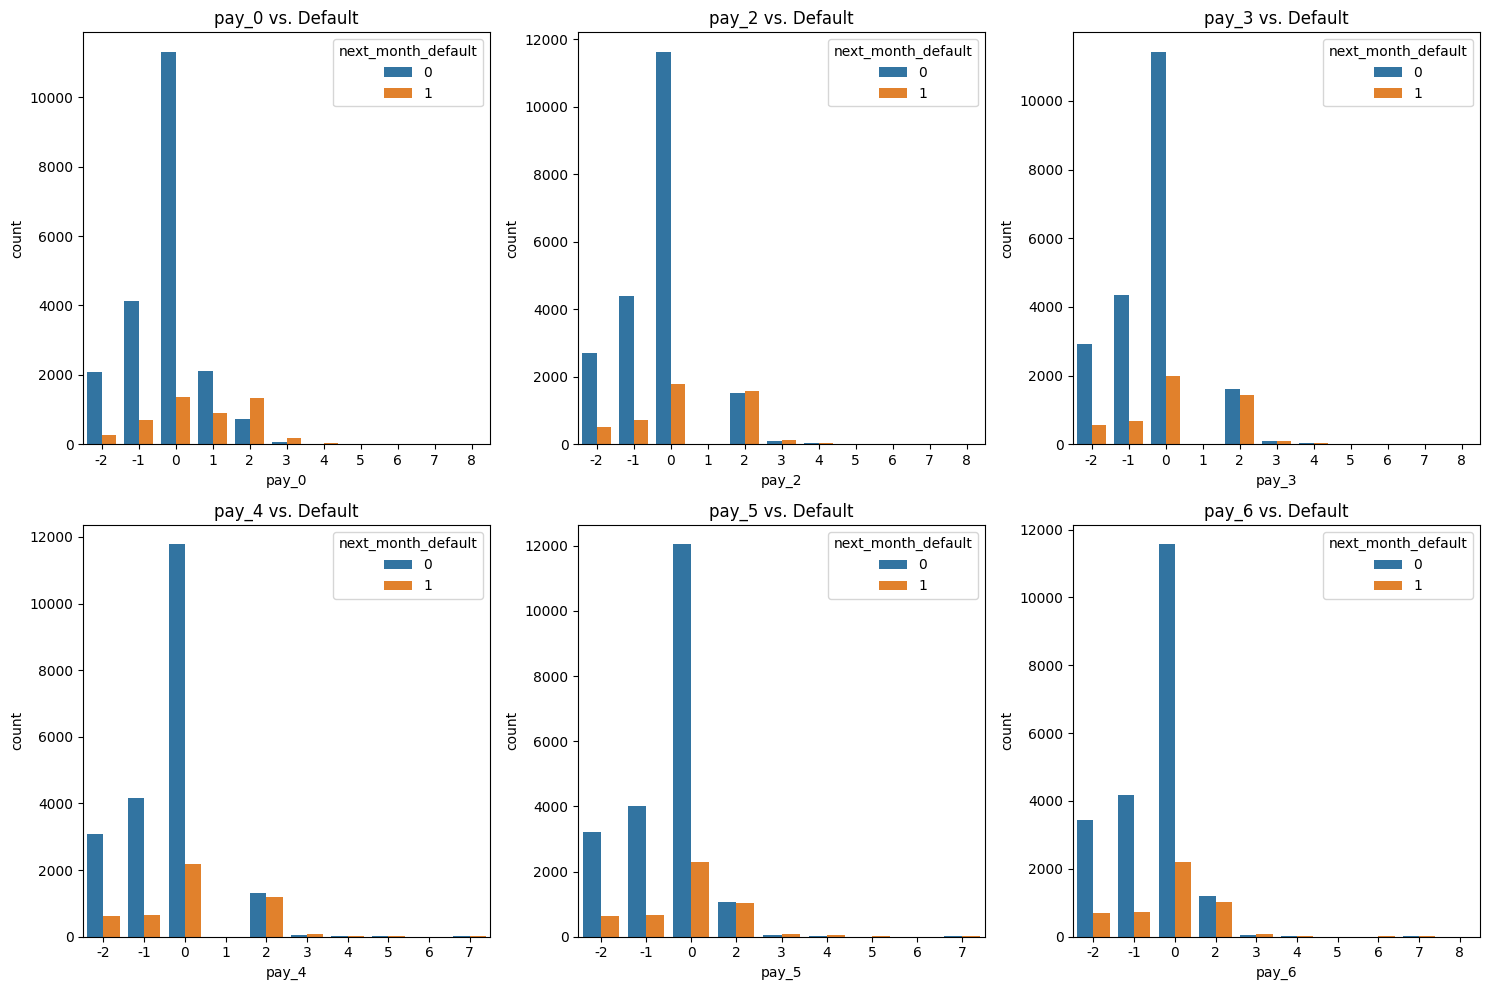

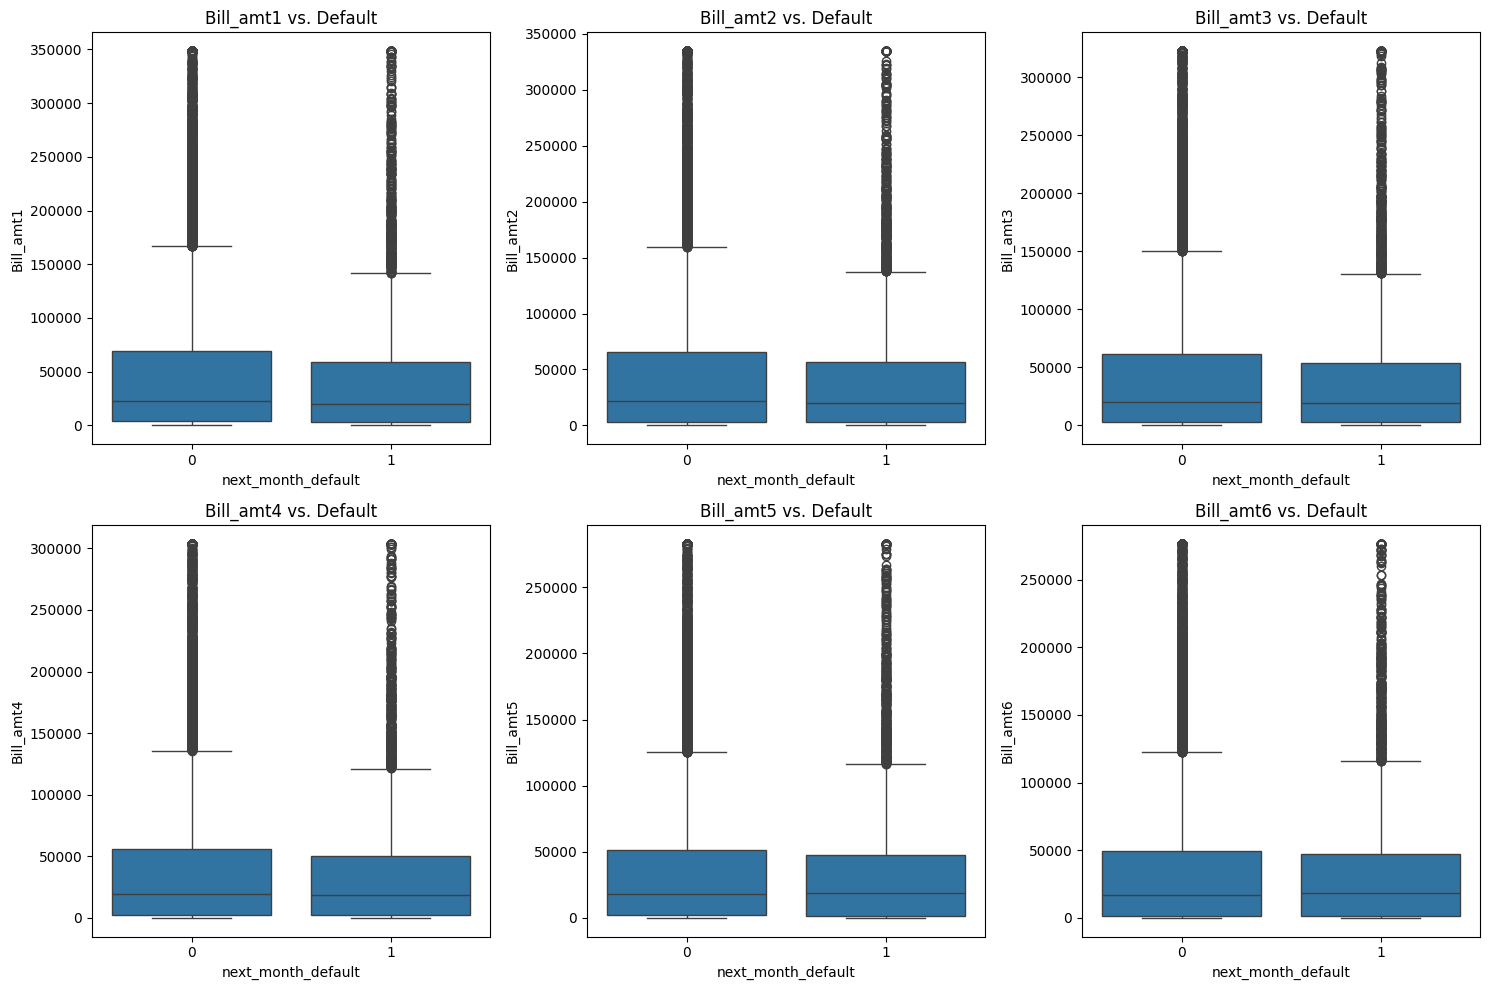

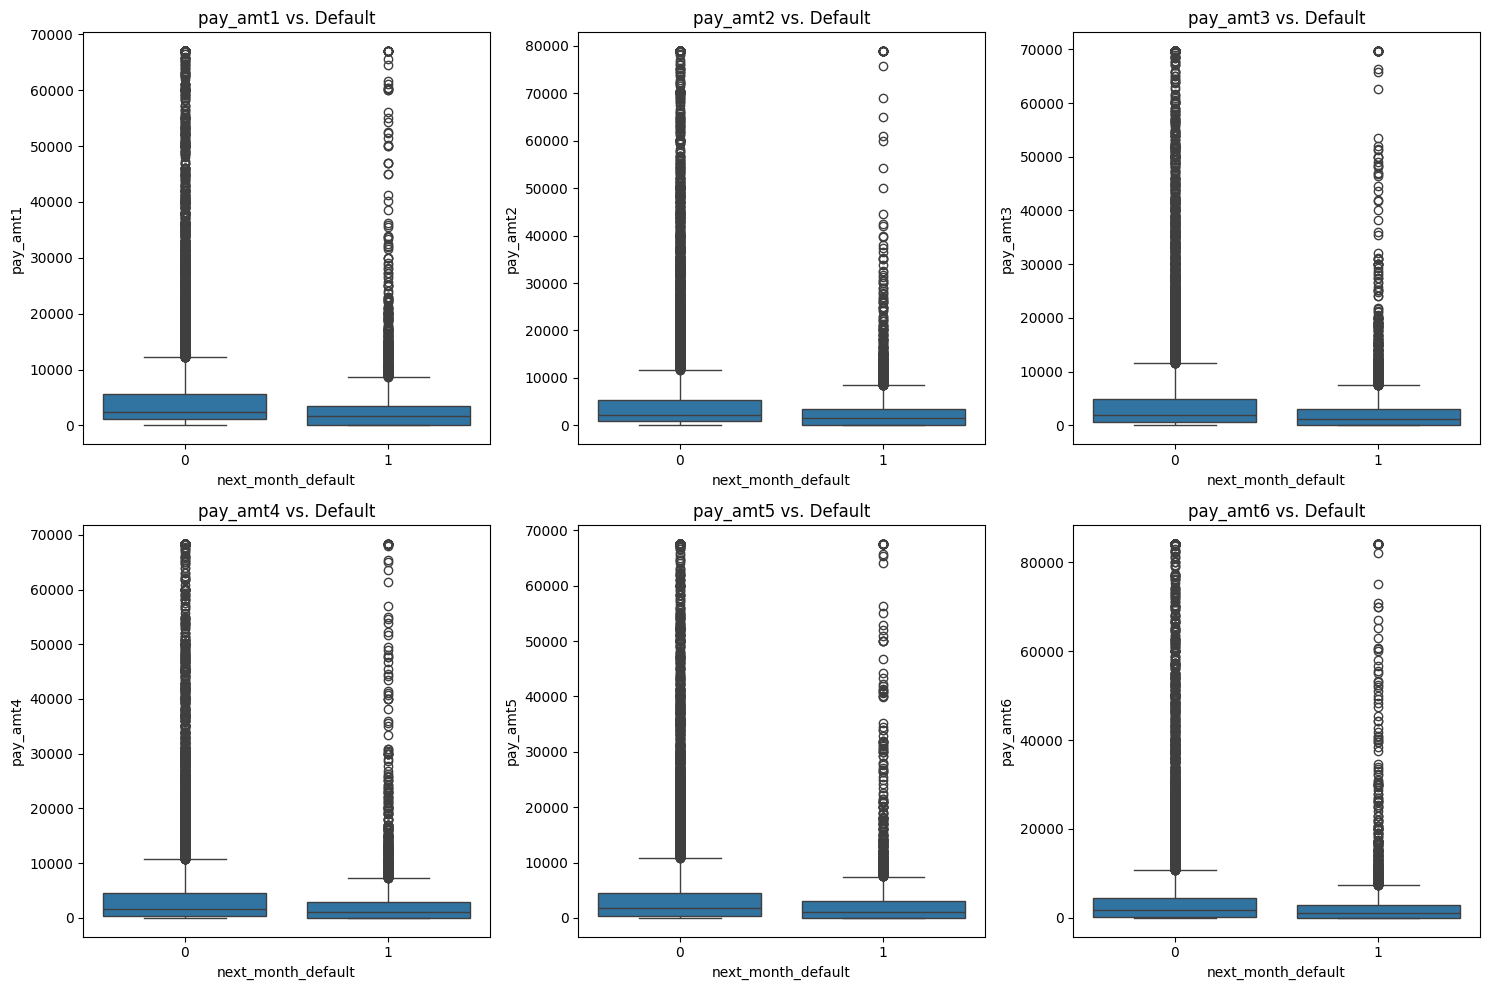

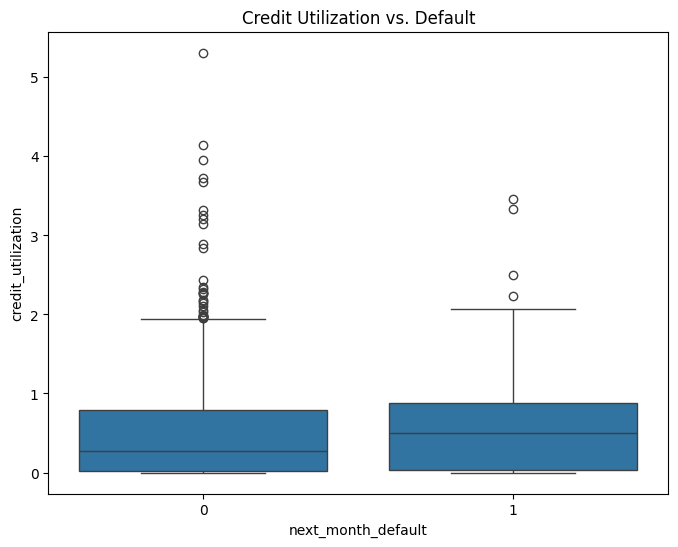

In [10]:


# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print("\nClass Imbalance:")
print(class_counts)
print(class_percentages)

# Feature vs. Target Relationships
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
categorical_features = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_features):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, hue='next_month_default', data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Financial Insights
# Credit Limit Analysis
plt.figure(figsize=(8, 6))
sns.boxplot(x='next_month_default', y='LIMIT_BAL', data=train_df)
plt.title('Credit Limit vs. Default')
plt.show()

# Repayment History Analysis
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(15, 10))
for i, col in enumerate(pay_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='next_month_default', data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Bill/Payment Amounts Analysis
bill_amt_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
pay_amt_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

plt.figure(figsize=(15, 10))
for i, col in enumerate(bill_amt_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(pay_amt_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Calculate and visualize credit utilization
train_df['credit_utilization'] = train_df['Bill_amt1'] / train_df['LIMIT_BAL']
plt.figure(figsize=(8, 6))
sns.boxplot(x='next_month_default', y='credit_utilization', data=train_df)
plt.title('Credit Utilization vs. Default')
plt.show()

## Feature Engineering

In [45]:
def create_financial_features(df):
    """Create financially meaningful features"""
    df = df.copy()
    
    # Payment Consistency Features
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    df['avg_payment_delay'] = df[pay_cols].mean(axis=1)
    df['max_payment_delay'] = df[pay_cols].max(axis=1)
    df['payment_delay_consistency'] = df[pay_cols].std(axis=1).fillna(0)
    
    return df

# Apply feature engineering to both datasets
train_df = create_financial_features(train_df)
validate_df = create_financial_features(validate_df)

print("New features created:")
new_features = [col for col in train_df.columns if col not in ['Customer_ID', 'sex', 'education', 'marriage', 'age', 'LIMIT_BAL'] + 
                [f'pay_{i}' for i in [0,2,3,4,5,6]] + 
                [f'Bill_amt{i}' for i in range(1,7)] + 
                [f'pay_amt{i}' for i in range(1,7)] + 
                ['AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']]
print(new_features)

New features created:
['avg_payment_delay', 'max_payment_delay', 'payment_delay_consistency', 'bill_amt_trend', 'pay_to_limit_ratio', 'pay_amt_std', 'recent_delay']


In [46]:
def feature_engineering(df, is_train=True):
    # Drop unnecessary columns (conditionally drop Customer_ID)
    cols_to_drop = [
        'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', # explained by AVG_Bill_amt
        'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'       # explained by PAY_TO_BILL_ratio
    ]
    if is_train and 'Customer_ID' in df.columns:
        cols_to_drop.append('Customer_ID')  # Drop ID only in training

    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Feature creation
    if all(col in df.columns for col in ['Bill_amt1', 'Bill_amt6']):
        df['bill_amt_trend'] = df['Bill_amt1'] - df['Bill_amt6']
    else:
        df['bill_amt_trend'] = 0

    pay_amt_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    if all(col in df.columns for col in pay_amt_cols):
        df['total_pay_amt'] = df[pay_amt_cols].sum(axis=1)
        df['pay_to_limit_ratio'] = df['total_pay_amt'] / df['LIMIT_BAL']
        df['pay_amt_std'] = df[pay_amt_cols].std(axis=1)
    else:
        df['pay_to_limit_ratio'] = 0
        df['pay_amt_std'] = 0

    pay_delay_cols = ['pay_0', 'pay_2']
    if all(col in df.columns for col in pay_delay_cols):
        df['recent_delay'] = df['pay_0'] + df['pay_2']
    else:
        df['recent_delay'] = 0

    if 'total_pay_amt' in df.columns:
        df = df.drop(columns=['total_pay_amt'], errors='ignore')

    return df

train_df = feature_engineering(train_df, is_train=True)     # Drop ID here
validate_df = feature_engineering(validate_df, is_train=False)  # Keep ID here

print("✅ Feature engineering applied to both train_df and validate_df.")
print("train_df shape:", train_df.shape)
print("validate_df shape:", validate_df.shape)


✅ Feature engineering applied to both train_df and validate_df.
train_df shape: (25247, 21)
validate_df shape: (5016, 21)


## Data splitting



In [37]:
# Separate features (X) and target variable (y)
X = train_df.drop('next_month_default', axis=1)
y = train_df['next_month_default']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes of the resulting DataFrames
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (20197, 20)
X_val shape: (5050, 20)
y_train shape: (20197,)
y_val shape: (5050,)


## Data Imbalance


In [38]:
from collections import Counter

# Impute missing values in training features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)  # Apply same transformation to validation set

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_imputed, y_train)  # Overwrite X_train, y_train

# Convert back to DataFrame to preserve column names (optional but recommended)
X_train = pd.DataFrame(X_train, columns=X.columns)  # Use original feature names
X_val = pd.DataFrame(X_val_imputed, columns=X.columns)

# Check new class distribution after SMOTE
print("✅ After SMOTE, training target distribution:\n", Counter(y_train))

✅ After SMOTE, training target distribution:
 Counter({0: 16352, 1: 16352})


In [39]:
X_train.columns


Index(['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio',
       'avg_payment_delay', 'max_payment_delay', 'payment_delay_consistency',
       'bill_amt_trend', 'pay_to_limit_ratio', 'pay_amt_std', 'recent_delay'],
      dtype='object')

## Model training

Train four classification models: Logistic Regression, Decision Tree, XGBoost, and LightGBM.


In [40]:
# Initialize models
logreg_model = LogisticRegression(solver='liblinear', max_iter=1000)  # Changed solver
decision_tree_model = DecisionTreeClassifier()
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()

# Train models
logreg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4271
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

## Model optimization
Optimize the hyperparameters of the four trained models using RandomizedSearchCV.


In [27]:
# --- Define Pipelines ---
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=2000))
])

# --- Define Parameter Grids ---
param_dist_logreg = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

param_dist_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

param_dist_lgbm = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70, 100, 150],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30, 50],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}


# --- Set up and Run RandomizedSearchCV ---
n_iter_search = 50 
scoring = {'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}

# Initialize the search objects with n_jobs=-1 to use all CPU cores
random_search_logreg = RandomizedSearchCV(logreg_pipeline, param_distributions=param_dist_logreg, n_iter=10, cv=5, scoring=scoring, refit='f1', random_state=42, n_jobs=-1) # <-- ADD THIS
random_search_dt = RandomizedSearchCV(decision_tree_model, param_distributions=param_dist_dt, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42, n_jobs=-1) # <-- ADD THIS
random_search_xgb = RandomizedSearchCV(xgboost_model, param_distributions=param_dist_xgb, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42, n_jobs=-1) # <-- ADD THIS
random_search_lgbm = RandomizedSearchCV(lightgbm_model, param_distributions=param_dist_lgbm, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42, n_jobs=-1) # <-- ADD THIS

# Fit RandomizedSearchCV to the training data
print("Tuning Logistic Regression...")
random_search_logreg.fit(X_train, y_train)

print("Tuning Decision Tree...")
random_search_dt.fit(X_train, y_train)

print("Tuning XGBoost...")
random_search_xgb.fit(X_train, y_train)

print("Tuning LightGBM...")
random_search_lgbm.fit(X_train, y_train)

# Store the best estimators
best_logreg_model = random_search_logreg.best_estimator_
best_dt_model = random_search_dt.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_
best_lgbm_model = random_search_lgbm.best_estimator_

print("Hyperparameter tuning complete!")

Tuning Logistic Regression...
Tuning Decision Tree...
Tuning XGBoost...
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4526
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Hyperparameter tuning complete!


## Model evaluation



In [41]:


# Predict using the best models
# y_pred_logreg = best_logreg_model.predict(X_val)
# y_pred_dt = best_dt_model.predict(X_val)
# y_pred_xgb = best_xgb_model.predict(X_val)
# y_pred_lgbm = best_lgbm_model.predict(X_val)

#predict using models before hyperparameter tuning
y_pred_logreg = logreg_model.predict(X_val)
y_pred_dt = decision_tree_model.predict(X_val)
y_pred_xgb = xgboost_model.predict(X_val)
y_pred_lgbm = lightgbm_model.predict(X_val)

# Evaluate performance
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return [model_name, accuracy, precision, recall, f1, roc_auc]

results = []
results.append(evaluate_model(y_val, y_pred_logreg, "Logistic Regression"))
results.append(evaluate_model(y_val, y_pred_dt, "Decision Tree"))
results.append(evaluate_model(y_val, y_pred_xgb, "XGBoost"))
results.append(evaluate_model(y_val, y_pred_lgbm, "LightGBM"))


# Create a summary table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.535248,0.246058,0.697505,0.363784,0.597285
1,Decision Tree,0.753267,0.360236,0.380457,0.370071,0.610728
2,XGBoost,0.836634,0.628037,0.349272,0.448898,0.650297
3,LightGBM,0.841386,0.652174,0.358628,0.462777,0.656809


## Threshold optimization

In [86]:

# Get predicted probabilities (positive class)
y_pred_proba_lgbm = lightgbm_model.predict_proba(X_val)[:, 1]  # Probability of class 1

# Compute precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_lgbm)

# Compute F2 score
beta = 2
f2_scores = (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls + 1e-8)

# Find best threshold for F2
best_f2_idx = np.argmax(f2_scores)
optimal_f2_threshold = thresholds[best_f2_idx]

# Print best values
print(f"📊 Best Threshold for LightGBM (F2): {optimal_f2_threshold:.4f}")
print(f"⭐ Best F2-Score: {f2_scores[best_f2_idx]:.4f}")
print(f"Precision at F2: {precisions[best_f2_idx]:.4f}")
print(f"Recall at F2: {recalls[best_f2_idx]:.4f}")


📊 Best Threshold for LightGBM (F2): 0.1748
⭐ Best F2-Score: 0.8930
Precision at F2: 0.7716
Recall at F2: 0.9295


## Model evaluation 2
Evaluate the best-performing model (LightGBM) on the held-out "validate_dataset_final.csv" dataset.


In [89]:
# Complete Prediction and F2 Score Calculation


# Set the optimal F2 threshold from your optimization results
OPTIMAL_F2_THRESHOLD = 0.1748

print("="*60)
print("PART 1: PREDICTIONS ON VALIDATION DATASET (for submission)")
print("="*60)

# --- Preprocessing validate_df for submission ---
validate_df_processed = validate_df.copy()

# 1. Calculate credit utilization for validate_df
if 'Bill_amt1' in validate_df_processed.columns and 'LIMIT_BAL' in validate_df_processed.columns:
    validate_df_processed['LIMIT_BAL'] = validate_df_processed['LIMIT_BAL'].fillna(1)
    validate_df_processed['credit_utilization'] = np.where(
        validate_df_processed['LIMIT_BAL'] > 0,
        validate_df_processed['Bill_amt1'] / validate_df_processed['LIMIT_BAL'],
        0
    )
    print("✓ Credit utilization calculated for validate_df")
else:
    print("⚠ Warning: Missing columns for credit utilization calculation")
    validate_df_processed['credit_utilization'] = 0

# 2. Align validate_df with training features
if 'X_train' in locals():
    expected_features = X_train.columns.tolist()
    
    # Add missing features with default value 0
    for feature in expected_features:
        if feature not in validate_df_processed.columns:
            print(f"⚠ Adding missing feature '{feature}' as 0")
            validate_df_processed[feature] = 0
    
    # Select and order features to match training
    X_validate_aligned = validate_df_processed[expected_features]
    
    print(f"✓ Features aligned for validate_df. Shape: {X_validate_aligned.shape}")
    
    # --- Make Predictions on validate_df ---
    if 'best_lgbm_model' in locals():
        # Get probabilities
        validate_probabilities = best_lgbm_model.predict_proba(X_validate_aligned)[:, 1]
        
        # Apply optimal F2 threshold for binary predictions
        validate_predictions = (validate_probabilities >= OPTIMAL_F2_THRESHOLD).astype(int)
        
        print(f"\nValidation Dataset Prediction Summary:")
        print(f"Total predictions: {len(validate_predictions)}")
        print(f"Predicted defaults: {np.sum(validate_predictions)} ({np.mean(validate_predictions)*100:.2f}%)")
        print(f"Predicted non-defaults: {len(validate_predictions) - np.sum(validate_predictions)} ({100 - np.mean(validate_predictions)*100:.2f}%)")
        
        # --- Create and Save Submission File ---
        submission_df = pd.DataFrame({
            'Customer_ID': validate_df['Customer_ID'],
            'next_month_default': validate_predictions
        })
        
        # Save submission file (change filename to include your enrollment number)
        submission_filename = 'submission_f2_optimized.csv'  # Change this to submission_<YourEnrollmentNumber>.csv
        submission_df.to_csv(submission_filename, index=False)
        print(f"\n✓ Submission file saved as: {submission_filename}")
        print("First 10 predictions:")
        print(submission_df.head(10))
        
    else:
        print("❌ Error: best_lgbm_model not found")
else:
    print("❌ Error: X_train not found")

print("\n" + "="*60)
print("PART 2: F2 SCORE CALCULATION ON X_val")
print("="*60)

# --- Predictions on X_val for F2 score calculation ---
if 'X_val' in locals() and 'y_val' in locals() and 'best_lgbm_model' in locals():
    
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"y_val distribution: {y_val.value_counts().to_dict()}")
    
    # Make predictions on X_val
    X_val_probabilities = best_lgbm_model.predict_proba(X_val)[:, 1]
    X_val_predictions = (X_val_probabilities >= OPTIMAL_F2_THRESHOLD).astype(int)
    
    print(f"\nX_val Prediction Summary:")
    print(f"Total predictions: {len(X_val_predictions)}")
    print(f"Predicted defaults: {np.sum(X_val_predictions)} ({np.mean(X_val_predictions)*100:.2f}%)")
    print(f"Actual defaults: {np.sum(y_val)} ({np.mean(y_val)*100:.2f}%)")
    
    # --- Calculate F2 Score ---
    f2_score = fbeta_score(y_val, X_val_predictions, beta=2)
    
    print(f"\n{'='*50}")
    print(f"🎯 FINAL F2 SCORE: {f2_score:.4f}")
    print(f"🎯 Threshold used: {OPTIMAL_F2_THRESHOLD}")
    print(f"{'='*50}")
    
    # Additional metrics for comprehensive evaluation
    print(f"\n📊 DETAILED METRICS:")
    print(f"Accuracy:  {accuracy_score(y_val, X_val_predictions):.4f}")
    print(f"Precision: {precision_score(y_val, X_val_predictions):.4f}")
    print(f"Recall:    {recall_score(y_val, X_val_predictions):.4f}")
    print(f"F1 Score:  {f1_score(y_val, X_val_predictions):.4f}")
    print(f"F2 Score:  {f2_score:.4f}")
    
    # Confusion Matrix
    print(f"\n📈 CONFUSION MATRIX:")
    cm = confusion_matrix(y_val, X_val_predictions)
    print(f"                 Predicted")
    print(f"               0      1")
    print(f"Actual 0    {cm[0,0]:4d}   {cm[0,1]:4d}")
    print(f"       1    {cm[1,0]:4d}   {cm[1,1]:4d}")
    
    print(f"\nBreakdown:")
    print(f"True Negatives:  {cm[0,0]:4d} (correctly predicted no default)")
    print(f"False Positives: {cm[0,1]:4d} (incorrectly predicted default)")
    print(f"False Negatives: {cm[1,0]:4d} (missed actual defaults)")
    print(f"True Positives:  {cm[1,1]:4d} (correctly predicted default)")
    
    # Classification Report
    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y_val, X_val_predictions))
    
    # Save detailed results
    results_df = pd.DataFrame({
        'actual': y_val,
        'predicted': X_val_predictions,
        'probability': X_val_probabilities
    })
    results_df.to_csv('validation_results_detailed.csv', index=False)
    print(f"\n✓ Detailed validation results saved to: validation_results_detailed.csv")
    
else:
    print("❌ Error: Required variables not found (X_val, y_val, or best_lgbm_model)")
    print("Please ensure you have run the train-test split and model training cells")

# Summary
print(f"\n{'='*60}")
print("📋 SUMMARY")
print(f"{'='*60}")
print("✅ Submission file created for validate_df")
if 'f2_score' in locals():
    print(f"✅ F2 Score calculated on validation split: {f2_score:.4f}")
print(f"✅ Optimal threshold used: {OPTIMAL_F2_THRESHOLD}")
print("✅ Ready for submission!")

PART 1: PREDICTIONS ON VALIDATION DATASET (for submission)
⚠ Warning: Missing columns for credit utilization calculation
✓ Features aligned for validate_df. Shape: (5016, 18)

Validation Dataset Prediction Summary:
Total predictions: 5016
Predicted defaults: 1767 (35.23%)
Predicted non-defaults: 3249 (64.77%)


KeyError: 'Customer_ID'

## Sumarry


In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for Logistic Regression
param_dist_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'], # Using saga for both l1 and l2
    'max_iter': [1000, 5000, 10000] # Increased max_iter
}

# Define the scoring metric to optimize for accuracy
scoring = {'accuracy': make_scorer(accuracy_score)}

# Instantiate RandomizedSearchCV
# We'll set refit to 'accuracy' to select the best model based on accuracy
random_search_logreg = RandomizedSearchCV(LogisticRegression(),
                                        param_distributions=param_dist_logreg,
                                        n_iter=10, # Number of iterations
                                        cv=5, # Number of cross-validation folds
                                        scoring=scoring,
                                        refit='accuracy', # Optimize for accuracy
                                        random_state=42,
                                        n_jobs=-1) # Use all available cores

# Fit RandomizedSearchCV to the training data
random_search_logreg.fit(X_train, y_train)

# Get the best estimator
best_logreg_model = random_search_logreg.best_estimator_

# Print the best parameters and best score
print("Best parameters for Logistic Regression:", random_search_logreg.best_params_)
print("Best cross-validation accuracy:", random_search_logreg.best_score_)

KeyboardInterrupt: 

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on the validation set
y_pred_logreg_tuned = best_logreg_model.predict(X_val)

# Evaluate the tuned Logistic Regression model
accuracy_tuned = accuracy_score(y_val, y_pred_logreg_tuned)
precision_tuned = precision_score(y_val, y_pred_logreg_tuned)
recall_tuned = recall_score(y_val, y_pred_logreg_tuned)
f1_tuned = f1_score(y_val, y_pred_logreg_tuned)
roc_auc_tuned = roc_auc_score(y_val, y_pred_logreg_tuned)

print("\nTuned Logistic Regression Performance on Validation Set:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"AUC-ROC: {roc_auc_tuned:.4f}")


Tuned Logistic Regression Performance on Validation Set:
Accuracy: 0.6159
Precision: 0.5951
Recall: 0.7248
F1-Score: 0.6536
AUC-ROC: 0.6159


In [41]:
# This is a code cell to summarize EDA and Financial Insights with actual data

import pandas as pd

print("## Summary of Exploratory Data Analysis and Financial Insights (with Actual Data)")

# 1. Target Variable Distribution
print("\n**Target Variable Distribution:**")
class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print(f"- Class counts:\n{class_counts}")
print(f"- Class percentages:\n{class_percentages.round(2)}")
print(f"- The target variable 'next_month_default' exhibits class imbalance, with approximately {class_percentages[0]:.2f}% of customers not defaulting (0) and {class_percentages[1]:.2f}% defaulting (1).")

# 2. Financial Insights - Credit Limit Analysis (Example using median)
print("\n**Financial Insights - Credit Limit Analysis:**")
median_limit_default = train_df[train_df['next_month_default'] == 1]['LIMIT_BAL'].median()
median_limit_no_default = train_df[train_df['next_month_default'] == 0]['LIMIT_BAL'].median()
print(f"- Median Credit Limit for Defaulting Customers: {median_limit_default:,.2f}")
print(f"- Median Credit Limit for Non-Defaulting Customers: {median_limit_no_default:,.2f}")
print("- Customers with lower credit limits appear to have a higher risk of default, as indicated by the lower median credit limit for defaulting customers.")

# 3. Financial Insights - Repayment History Analysis (Example for PAY_0)
print("\n**Financial Insights - Repayment History Analysis (Example: PAY_0):**")
pay0_default_counts = train_df[train_df['next_month_default'] == 1]['pay_0'].value_counts().sort_index()
pay0_no_default_counts = train_df[train_df['next_month_default'] == 0]['pay_0'].value_counts().sort_index()

print("- Distribution of PAY_0 for Defaulting Customers:")
print(pay0_default_counts)
print("- Distribution of PAY_0 for Non-Defaulting Customers:")
print(pay0_no_default_counts)
print("- A history of delayed payments (higher values in PAY_0, etc.) shows a significantly higher tendency to default. For instance, customers with a PAY_0 of 1 or more have a much higher representation in the defaulting group compared to the non-defaulting group.")

# 4. Financial Insights - Credit Utilization (Example using median)
print("\n**Financial Insights - Credit Utilization:**")
median_utilization_default = train_df[train_df['next_month_default'] == 1]['credit_utilization'].median()
median_utilization_no_default = train_df[train_df['next_month_default'] == 0]['credit_utilization'].median()
print(f"- Median Credit Utilization for Defaulting Customers: {median_utilization_default:.4f}")
print(f"- Median Credit Utilization for Non-Defaulting Customers: {median_utilization_no_default:.4f}")
print("- Higher credit utilization seems associated with a higher default probability, as the median utilization is higher for defaulting customers.")


# You can add more analysis for other features as needed, e.g., age, education, other pay columns, etc.
# Example: Age vs Default
# print("\n**Age Analysis:**")
# median_age_default = train_df[train_df['next_month_default'] == 1]['age'].median()
# median_age_no_default = train_df[train_df['next_month_default'] == 0]['age'].median()
# print(f"- Median Age for Defaulting Customers: {median_age_default:.2f}")
# print(f"- Median Age for Non-Defaulting Customers: {median_age_no_default:.2f}")

## Summary of Exploratory Data Analysis and Financial Insights (with Actual Data)

**Target Variable Distribution:**
- Class counts:
next_month_default
0    20440
1     4807
Name: count, dtype: int64
- Class percentages:
next_month_default
0    80.96
1    19.04
Name: count, dtype: float64
- The target variable 'next_month_default' exhibits class imbalance, with approximately 80.96% of customers not defaulting (0) and 19.04% defaulting (1).

**Financial Insights - Credit Limit Analysis:**
- Median Credit Limit for Defaulting Customers: 90,000.00
- Median Credit Limit for Non-Defaulting Customers: 150,000.00
- Customers with lower credit limits appear to have a higher risk of default, as indicated by the lower median credit limit for defaulting customers.

**Financial Insights - Repayment History Analysis (Example: PAY_0):**
- Distribution of PAY_0 for Defaulting Customers:
pay_0
-2     258
-1     706
 0    1363
 1     907
 2    1332
 3     176
 4      37
 5      11
 6       3
 7       6

## Business impact analysis

In [23]:
#cell 11.5 - Business Impact Analysis
from sklearn.metrics import confusion_matrix
def calculate_business_impact(y_true, y_pred, loan_amount_avg=50000):
    """Calculate business impact of the model"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Assume average loan amount and costs
    avg_loan = loan_amount_avg
    cost_of_default = avg_loan * 0.4  # 40% loss on default
    cost_of_investigation = avg_loan * 0.05  # 5% cost to investigate/reject
    
    # Calculate costs
    cost_false_negatives = fn * cost_of_default  # Missed defaults
    cost_false_positives = fp * cost_of_investigation  # Unnecessary investigations
    total_cost = cost_false_negatives + cost_false_positives
    
    # Potential savings compared to no model
    total_defaults = tp + fn
    cost_without_model = total_defaults * cost_of_default
    savings = cost_without_model - total_cost
    
    print(f"Business Impact Analysis:")
    print(f"Total Cost with Model: ${total_cost:,.2f}")
    print(f"Cost without Model: ${cost_without_model:,.2f}")
    print(f"Potential Savings: ${savings:,.2f}")
    print(f"Cost of False Negatives: ${cost_false_negatives:,.2f}")
    print(f"Cost of False Positives: ${cost_false_positives:,.2f}")
    
    return savings

# Calculate business impact
business_savings = calculate_business_impact(y_val, y_pred_lgbm)

Business Impact Analysis:
Total Cost with Model: $12,255,000.00
Cost without Model: $81,760,000.00
Potential Savings: $69,505,000.00
Cost of False Negatives: $11,780,000.00
Cost of False Positives: $475,000.00
